## Import packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import os
import mne
import pickle
import itertools

from numba import jit, cuda

import pac

from joblib import Parallel, delayed
import Get_global_local_feature

## Get global feature using convolution

## Working on Kiani's PAC
### new pipline with normalization of channel
load PAC

In [ ]:
a = np.load('..\data\mvl_2ds_1_50.npz')
PAC = a['mvl_2ds']*1e-12
Test = Get_global_local_feature.conv_PAC_dist(PAC[0,0,0,0,0:64,:],h=4,w=4,down_sample_factor_h=4,down_sample_factor_w=4)
Test.shape

In [ ]:
PAC_feature_sub_on_electrodes = np.zeros(shape=(3,25,3,63,16,4))
@jit
def PAC_caluculation():
    for i in np.arange(3):
        for j in np.arange(3):
            for ch in np.arange(63):
                for sub in np.arange(25): 
                    PAC_feature_sub_on_electrodes[i,sub,j,ch,:,:] = Get_global_local_feature.conv_PAC_dist(PAC[i,sub,j,ch,0:64,:],h=4,w=4,down_sample_factor_h=4,down_sample_factor_w=4)

if __name__ == "__main__":
    PAC_caluculation()
    np.save(f'..\data\Feature_window_dimension_4_4.npy',PAC_feature_sub_on_electrodes)


### Load feature and set parameter

#### Get indexes of selected channels

In [ ]:
# PAC_feature_sub_on_electrodes = np.load(f'..\data\Feature_window_dimension_4_4.npy')
groups = ['PD Med on', 'PD Med Off', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']
with open('../data/channels_name.pkl', 'rb') as f:
    channels_name = pickle.load(f)
# selected_channels = ['Fz','Pz','Cz','FCz']
selected_channels = ['FC3','FC4','AF3','AF4','F3','F4']

# selected_channels = ['FCz']
list_index = [channels_name.index(i) for i in selected_channels]
list_index 

In [ ]:
list_index

In [ ]:
# # Here load a matrix with shape of 3,25,3,63,num_High_fre,num_Low_fre,num_time_window=6 cotaining PAC values
# Path = '/home/moh/Desktop/Surprise/Codes/brainsurprise2/brainsurprise/data/PAC_time_feature_5_30_10_100.mmap'
# Num_High_fre = 91
# Num_Low_fre = 26
# PAC_distribution_time_window = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_fre ,Num_Low_fre,6),mode='r+')
# index_sorted = np.zeros(shape=(9*25*4*Num_Low_fre*Num_High_fre,6))
# counter=0

# for i in np.arange(3):
#     for sub in np.arange(25):
#         for j in np.arange(3):
#             for ch in list_index:
#                 for h in np.arange(Num_High_fre):
#                     for l in np.arange(Num_Low_fre):
#                         if np.any(PAC_distribution_time_window[i,sub,j,ch,h,l,:]==0):
#                             index_sorted[counter,:] = [i,sub,j,ch,h,l]
#                         counter = counter + 1 
# print(index_sorted.max())


In [ ]:
# # Test
# i = 1
# PAC_feature_time_window = np.zeros(shape=(3,25,3,63,Num_High_feature,Num_Low_feature,6))
# PAC_feature_time_window[1,1,1,1,:,:,1] = Get_global_local_feature.conv_PAC_dist(PAC_distribution_time_window[1,1,1,1,:,:,1],
#                                          h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)
# i=1

## Get Local Features for total PAC

#### Load PAC total of kiani

In [13]:
Num_High_fre = 200
Num_Low_fre = 50
Save_path = '../data/Check_PAC_double_calculation/MVL_2ds__1_200_double.mmap'
PAC_total_kiani= np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_fre ,Num_Low_fre),mode='r')
print(PAC_total_kiani.shape)
print(np.max(PAC_total_kiani))
print(np.any(PAC_total_kiani == 0))

(3, 25, 3, 63, 200, 50)
38847763905118.42
False


In [ ]:
# Here load a matrix with shape of 3,25,3,63,num_High_fre,num_Low_fre,num_time_window=6 cotaining PAC values
# Path = '/home/moh/Desktop/Surprise/Codes/brainsurprise2/brainsurprise/data/PAC_time_feature_5_30_10_100_frontal_regions.mmap'
# Num_High_fre = 91
# Num_Low_fre = 26
# PAC_distribution_time_window = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_fre ,Num_Low_fre,6),mode='r+')


# here you can set the dimention of Kernel filter and save path for 
Convolution_window_h = 4
Convolution_window_l = 4
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
Save_path = f'../data/PAC_total_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_total = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature),mode='w+')
print(PAC_feature_total.shape)

# Test

# PAC_feature_time_window[1,1,1,1,:,:,1] = Get_global_local_feature.conv_PAC_dist(PAC_distribution_time_window[1,1,1,1,:,:,1],
#                                          h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)


# PAC_feature_time_window = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_low_feature,6),mode='w+')
# window_size = 200 # in ms
# down_sample_factor = 1
# window_sample = int(window_size*(0.5/down_sample_factor))
# # frequency_h_n = 76
# # frequency_l_n = 23
# start_high_frequency = 10
# end_high_frequency = 100
# start_low_frequency = 5
# end_low_frequency = 30

# frequency_h_n = end_high_frequency-start_high_frequency + 1
# frequency_l_n = end_low_frequency-start_low_frequency + 1

# frequency_range_high = np.linspace(start_high_frequency,end_high_frequency,frequency_h_n).astype(np.int64)
# frequency_range_low = np.linspace(start_low_frequency,end_low_frequency,frequency_l_n).astype(np.int64)

# attention !!!! attention !!!! 
# If you run this cell for the second time or more, after possible crash in middle of the first run, you have to change the 
# "load mode" of np.mmap from 'w+' to 'r+', ohterwise, all the saved calculation, unitll the middle of the first run
# are going to be removed by loading in 'w+' mode. After this change, there is no need to be worry of deleting previous 
# calculation you have done in next runs.


# PAC_feature_sub_on_electrodes = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63,frequency_h_n ,frequency_l_n,6),mode='r+')
# PAC_feature_sub_on_electrodes = np.zeros([3, 25, 3, 63,frequency_h_n ,frequency_l_n,6])
# print(PAC_feature_sub_on_electrodes.flags)
def wrapper(i,sub,j,ch):
    PAC_feature_total[i,sub,j,ch,:,:] = Get_global_local_feature.conv_PAC_dist(PAC_total_kiani[i,sub,j,ch,:,:],
                                         h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)



Parallel(n_jobs=8,verbose=10)(delayed(wrapper)(i,sub,j,ch) for i in np.arange(3) for sub in np.arange(25) for j in np.arange(3) for ch in np.arange(63))

## Get Local Features for time PAC series


#### Load PAC time series of kiani

In [9]:
Num_High_feature = 200
Num_Low_feature = 50
Save_path = '../data/Check_PAC_double_calculation/PAC_time__1_200_double.mmap'
PAC_time_series_kiani= np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r')
print(PAC_time_series_kiani.shape)
print(np.max(PAC_time_series_kiani))

(3, 25, 3, 63, 200, 50, 6)
43524710864530.125


In [ ]:
# Here load a matrix with shape of 3,25,3,63,num_High_fre,num_Low_fre,num_time_window=6 cotaining PAC values
# Path = '/home/moh/Desktop/Surprise/Codes/brainsurprise2/brainsurprise/data/PAC_time_feature_5_30_10_100_frontal_regions.mmap'
# Num_High_fre = 91
# Num_Low_fre = 26
# PAC_distribution_time_window = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_fre ,Num_Low_fre,6),mode='r+')


# here you can set the dimention of Kernel filter and save path for 
Convolution_window_h = 4
Convolution_window_l = 4
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
Save_path = f'../data/PAC_time_series_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_time_window = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='w+')
print(PAC_feature_time_window.shape)
# Test

# PAC_feature_time_window[1,1,1,1,:,:,1] = Get_global_local_feature.conv_PAC_dist(PAC_distribution_time_window[1,1,1,1,:,:,1],
#                                          h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)


# PAC_feature_time_window = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_low_feature,6),mode='w+')
# window_size = 200 # in ms
# down_sample_factor = 1
# window_sample = int(window_size*(0.5/down_sample_factor))
# # frequency_h_n = 76
# # frequency_l_n = 23
# start_high_frequency = 10
# end_high_frequency = 100
# start_low_frequency = 5
# end_low_frequency = 30

# frequency_h_n = end_high_frequency-start_high_frequency + 1
# frequency_l_n = end_low_frequency-start_low_frequency + 1

# frequency_range_high = np.linspace(start_high_frequency,end_high_frequency,frequency_h_n).astype(np.int64)
# frequency_range_low = np.linspace(start_low_frequency,end_low_frequency,frequency_l_n).astype(np.int64)

# attention !!!! attention !!!! 
# If you run this cell for the second time or more, after possible crash in middle of the first run, you have to change the 
# "load mode" of np.mmap from 'w+' to 'r+', ohterwise, all the saved calculation, unitll the middle of the first run
# are going to be removed by loading in 'w+' mode. After this change, there is no need to be worry of deleting previous 
# calculation you have done in next runs.


# PAC_feature_sub_on_electrodes = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63,frequency_h_n ,frequency_l_n,6),mode='r+')
# PAC_feature_sub_on_electrodes = np.zeros([3, 25, 3, 63,frequency_h_n ,frequency_l_n,6])
# print(PAC_feature_sub_on_electrodes.flags)
def wrapper(i,sub,j,ch):
    for t in np.arange(6):
        PAC_feature_time_window[i,sub,j,ch,:,:,t] = Get_global_local_feature.conv_PAC_dist(PAC_time_series_kiani[i,sub,j,ch,:,:,t],
                                         h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)



Parallel(n_jobs=8,verbose=10)(delayed(wrapper)(i,sub,j,ch) for i in np.arange(3) for sub in np.arange(25) for j in np.arange(3) for ch in np.arange(63))

### Check nonzero value for PAC feature of kiani time series and total

In [11]:
index_sorted = np.zeros(shape=(9*25*63*Num_Low_feature*Num_High_feature,6))
counter=0
for i in np.arange(3):
    for sub in np.arange(25):
        for j in np.arange(3):
            for ch in np.arange(63):
                for h in np.arange(Num_High_feature):
                    for l in np.arange(Num_Low_feature):
                        if np.any(PAC_feature_total[i,sub,j,ch,h,l]==0):
                            index_sorted[counter,:] = [i,sub,j,ch,h,l]
                        counter = counter + 1 
print(index_sorted.max())

0.0


In [12]:
index_sorted = np.zeros(shape=(9*25*63*Num_Low_feature*Num_High_feature,6))
print(PAC_feature_time_window.shape)
counter=0
for i in np.arange(3):
    for sub in np.arange(25):
        for j in np.arange(3):
            for ch in np.arange(63):
                for h in np.arange(Num_High_feature):
                    for l in np.arange(Num_Low_feature):
                        if np.any(PAC_feature_time_window[i,sub,j,ch,h,l,:]==0):
                            index_sorted[counter,:] = [i,sub,j,ch,h,l]
                        counter = counter + 1 
print(index_sorted.max())

(3, 25, 3, 63, 50, 12, 6)
0.0


In [13]:
Save_path = f'../data/PAC_time_series_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_time_window1 = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r+')
print(PAC_feature_time_window.shape)
print(PAC_feature_time_window1.shape)
np.any(PAC_feature_time_window != PAC_feature_time_window1)

(3, 25, 3, 63, 50, 12, 6)
(3, 25, 3, 63, 50, 12, 6)


False

In [15]:
Save_path = f'../data/PAC_total_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_total1 = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature),mode='r+')
print(PAC_feature_total.shape)
print(PAC_feature_total1.shape)
np.any(PAC_feature_total != PAC_feature_total1)

(3, 25, 3, 63, 50, 12)
(3, 25, 3, 63, 50, 12)


False

## Get Local Features for mutual total PAC 

#### Load PAC mutual feeture of kiani

In [3]:
Num_High_fre = 200
Num_Low_fre = 50
Save_path = '../data/Check_PAC_double_calculation/MVL_cross__1_200_double.mmap'
PAC_cross_series_kiani= np.memmap(Save_path,dtype=float ,shape=(3, 25, 3,10,10,Num_High_fre ,Num_Low_fre),mode='r')
print(PAC_cross_series_kiani.shape)
print(np.max(PAC_cross_series_kiani))
print(np.any(PAC_cross_series_kiani == 0))

(3, 25, 3, 10, 10, 200, 50)
30313644787556.08
False


In [6]:
# Here load a matrix with shape of 3,25,3,63,num_High_fre,num_Low_fre,num_time_window=6 cotaining PAC values
# Path = '/home/moh/Desktop/Surprise/Codes/brainsurprise2/brainsurprise/data/PAC_time_feature_5_30_10_100_frontal_regions.mmap'
# Num_High_fre = 91
# Num_Low_fre = 26
# PAC_distribution_time_window = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_fre ,Num_Low_fre,6),mode='r+')


# here you can set the dimention of Kernel filter and save path for 
Convolution_window_h = 4
Convolution_window_l = 4
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
Save_path = f'../data/PAC_total_cross_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_total_cross = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 10,10, Num_High_feature ,Num_Low_feature),mode='w+')
print(PAC_feature_total_cross.shape)

# Test

# PAC_feature_time_window[1,1,1,1,:,:,1] = Get_global_local_feature.conv_PAC_dist(PAC_distribution_time_window[1,1,1,1,:,:,1],
#                                          h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)


# PAC_feature_time_window = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_low_feature,6),mode='w+')
# window_size = 200 # in ms
# down_sample_factor = 1
# window_sample = int(window_size*(0.5/down_sample_factor))
# # frequency_h_n = 76
# # frequency_l_n = 23
# start_high_frequency = 10
# end_high_frequency = 100
# start_low_frequency = 5
# end_low_frequency = 30

# frequency_h_n = end_high_frequency-start_high_frequency + 1
# frequency_l_n = end_low_frequency-start_low_frequency + 1

# frequency_range_high = np.linspace(start_high_frequency,end_high_frequency,frequency_h_n).astype(np.int64)
# frequency_range_low = np.linspace(start_low_frequency,end_low_frequency,frequency_l_n).astype(np.int64)

# attention !!!! attention !!!! 
# If you run this cell for the second time or more, after possible crash in middle of the first run, you have to change the 
# "load mode" of np.mmap from 'w+' to 'r+', ohterwise, all the saved calculation, unitll the middle of the first run
# are going to be removed by loading in 'w+' mode. After this change, there is no need to be worry of deleting previous 
# calculation you have done in next runs.


# PAC_feature_sub_on_electrodes = np.memmap('..\data\Test.mmap',dtype=float ,shape=(3, 25, 3, 63,frequency_h_n ,frequency_l_n,6),mode='r+')
# PAC_feature_sub_on_electrodes = np.zeros([3, 25, 3, 63,frequency_h_n ,frequency_l_n,6])
# print(PAC_feature_sub_on_electrodes.flags)
def wrapper(i,sub,j,ch,ch1):
    PAC_feature_total_cross[i,sub,j,ch,ch1,:,:] = Get_global_local_feature.conv_PAC_dist(PAC_cross_series_kiani[i,sub,j,ch,ch1,:,:],
                                         h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)



Parallel(n_jobs=8,verbose=10)(delayed(wrapper)(i,sub,j,ch,ch1) for i in np.arange(3) for sub in np.arange(25) for j in np.arange(3) for ch in np.arange(10) for ch1 in np.arange(10))


(3, 25, 3, 10, 10, 50, 12)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1752s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0461s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  53 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0381s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done  81 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 137 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0418s.) Setting batch_size=16.
[Parallel(n_jobs=8)]: Done 230 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Batch computation too fas

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
index_sorted = np.zeros(shape=(9*25*10*10*Num_Low_feature*Num_High_feature))
counter=0
for i in np.arange(3):
    for sub in np.arange(25):
        for j in np.arange(3):
            for ch in np.arange(10):
                for ch1 in np.arange(10):
                    for h in np.arange(Num_High_feature):
                        for l in np.arange(Num_Low_feature):
                            if np.any(PAC_feature_total_cross[i,sub,j,ch,ch1,h,l]==0):
                                index_sorted[counter,:] = [i,sub,j,ch,ch1,h,l]
                            counter = counter + 1 
print(index_sorted.max())

In [9]:
print(np.any(PAC_feature_total_cross==0))
Save_path = f'../data/PAC_total_cross_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_total_cross1 = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 10,10, Num_High_feature ,Num_Low_feature),mode='r')
print(np.any(PAC_feature_total1 != PAC_feature_total))



False
False


## Get local feature of mutual PAC time series

In [2]:
Num_High_fre = 200
Num_Low_fre = 50
Save_path = '../data/Check_mutual_PAC_double/original.mmap'
PAC_mutual_kiani_time_series= np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 10, 10, Num_High_fre ,Num_Low_fre, 6),mode='r')
print(PAC_mutual_kiani_time_series.shape)
print(np.max(PAC_mutual_kiani_time_series))
print(np.any(PAC_mutual_kiani_time_series == 0))

(3, 25, 3, 10, 10, 200, 50, 6)
39278921166711.41
False


In [3]:
Convolution_window_h = 4
Convolution_window_l = 4
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
Save_path = f'../data/PAC_time_series_cross_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_time_series_cross = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 10,10, Num_High_feature ,Num_Low_feature,6),mode='w+')
print(PAC_feature_time_series_cross.shape)


def wrapper(i,sub,j,ch,ch1,t):
    PAC_feature_time_series_cross[i,sub,j,ch,ch1,:,:,t] = Get_global_local_feature.conv_PAC_dist(PAC_mutual_kiani_time_series[i,sub,j,ch,ch1,:,:,t],
                                         h=Convolution_window_h,w=Convolution_window_l,down_sample_factor_w=Convolution_window_l,down_sample_factor_h=Convolution_window_h)



Parallel(n_jobs=8,verbose=10)(delayed(wrapper)(i,sub,j,ch,ch1,t) for i in np.arange(3) for sub in np.arange(25) for j in np.arange(3) for ch in np.arange(10) for ch1 in np.arange(10) for t in np.arange(6))




(3, 25, 3, 10, 10, 50, 12, 6)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1800s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0067s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  50 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0085s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done 124 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0176s.) Setting batch_size=16.
[Parallel(n_jobs=8)]: Done 216 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Batch computation too fas

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [4]:
print(np.any(PAC_feature_time_series_cross==0))
Save_path = f'../data/PAC_time_series_cross_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_time_series_cross1 = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 10,10, Num_High_feature ,Num_Low_feature,6),mode='r')
print(np.any(PAC_feature_time_series_cross1!= PAC_feature_time_series_cross))

False
False


## Plot time series of PAC value 
### types of plot
#### Grand meen of dynamic of PAC

##### Load PAC feature time series


In [ ]:
Path_1 = '../data/PAC_time_series_convolution_feature_10_100_5_30_4_4.mmap'
# Path_2 = f'../data/PAC_time_series_convolution_feature_10_100_5_30_{Convolution_window_h}_{Convolution_window_l}_frontal_regions.mmap'
Num_High_fre = 91
Num_Low_fre = 26
Convolution_window_h = 4
Convolution_window_l = 4
Path_2 = f'../data/PAC_time_series_convolution_feature_10_100_5_30_{Convolution_window_h}_{Convolution_window_l}_frontal_regions.mmap'
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
PAC_feature_central_regions = np.memmap(Path_1,dtype=float, shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r+')
PAC_feature_forental_regions = np.memmap(Path_2,dtype=float, shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r+')


In [ ]:
print(np.max(PAC_feature_central_regions[2,24,2,12,:,:,3]))
print(np.max(PAC_feature_forental_regions[2,24,2,2,:,:,3]))
print(PAC_feature_central_regions.shape)
print(PAC_feature_forental_regions.shape)

### Load PAC feature total of kiani double

In [2]:
Path = '../data/PAC_total_convolution_feature_1_200_1_50_4_4_double.mmap'

Num_High_feature ,Num_Low_feature = 50, 12

PAC_feature_total = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature),mode='r')

print(PAC_feature_total.shape)
print(np.max(PAC_feature_total))
print(np.any(PAC_feature_total==0))




(3, 25, 3, 63, 50, 12)
18555932612919.055
False


#### Check that the calculation is based on my expectation

In [ ]:
print(PAC_feature_total[0,0,0,0,49,2])
print(np.sum(PAC_total_kiani[0,0,0,0,196:200,8:12])/16)



## Plot grand mean PAC total topography 

#### Load channel names and set some neccessary parameter

In [13]:
with open('../data/channels_name.pkl', 'rb') as f:
    channels_name = pickle.load(f)

groups = ['PD Med off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']

(3, 3, 63)


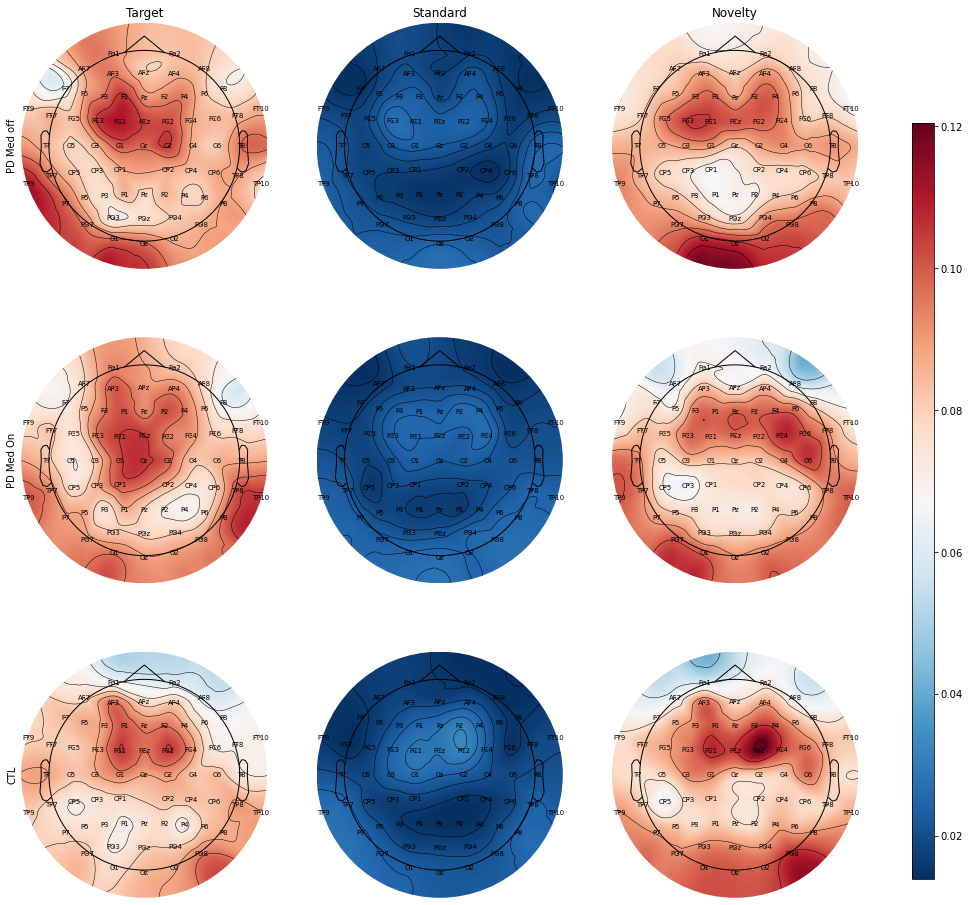

In [4]:
feature_l = 1

feature_h = 10

PAC_feature_total_grand_mean = np.mean(PAC_feature_total[:,:,:,:,feature_h,feature_l],axis=1)*1e-12
print(PAC_feature_total_grand_mean.shape)

vmax = PAC_feature_total_grand_mean.max()
vmin = PAC_feature_total_grand_mean.min()  

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))

mne_info = mne.create_info(ch_names=channels_name, sfreq=500., ch_types='eeg')

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')

for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    temp = np.expand_dims(PAC_feature_total_grand_mean[i,j,:],axis=1)
    PAC_grand_mean = mne.EvokedArray(temp,mne_info)
    PAC_grand_mean.set_montage(montage)
    im, cm = mne.viz.plot_topomap(PAC_grand_mean.data[:,0], 
                                  PAC_grand_mean.info, axes=axs[i, j], show=False,
                                  names=channels_name, show_names=True, 
                                  vmin=vmin, vmax=vmax,res=200,cmap= 'RdBu_r')

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])
        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
# fname = f'PAC_grand_mean_dur_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}.png' 
       
# if start_time == -200 and end_time==1000:
#         Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-total-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
# else:
#         Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-time_window-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
       
# if not os.path.isdir(Path_dir):
#         os.mkdir(Path_dir)

# file_path = os.path.join(Path_dir,fname)


# plt.savefig(file_path)

## Plot grand mean for PAC time window

In [3]:
Path = '../data/PAC_time_series_convolution_feature_1_200_1_50_4_4_double.mmap'

Num_High_feature ,Num_Low_feature = 50, 12

PAC_feature_time_window = np.memmap(Path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r')

print(PAC_feature_time_window.shape)
print(np.max(PAC_feature_time_window))
print(np.any(PAC_feature_time_window == 0))


(3, 25, 3, 63, 50, 12, 6)
37898248475812.64
False


(3, 3, 63)


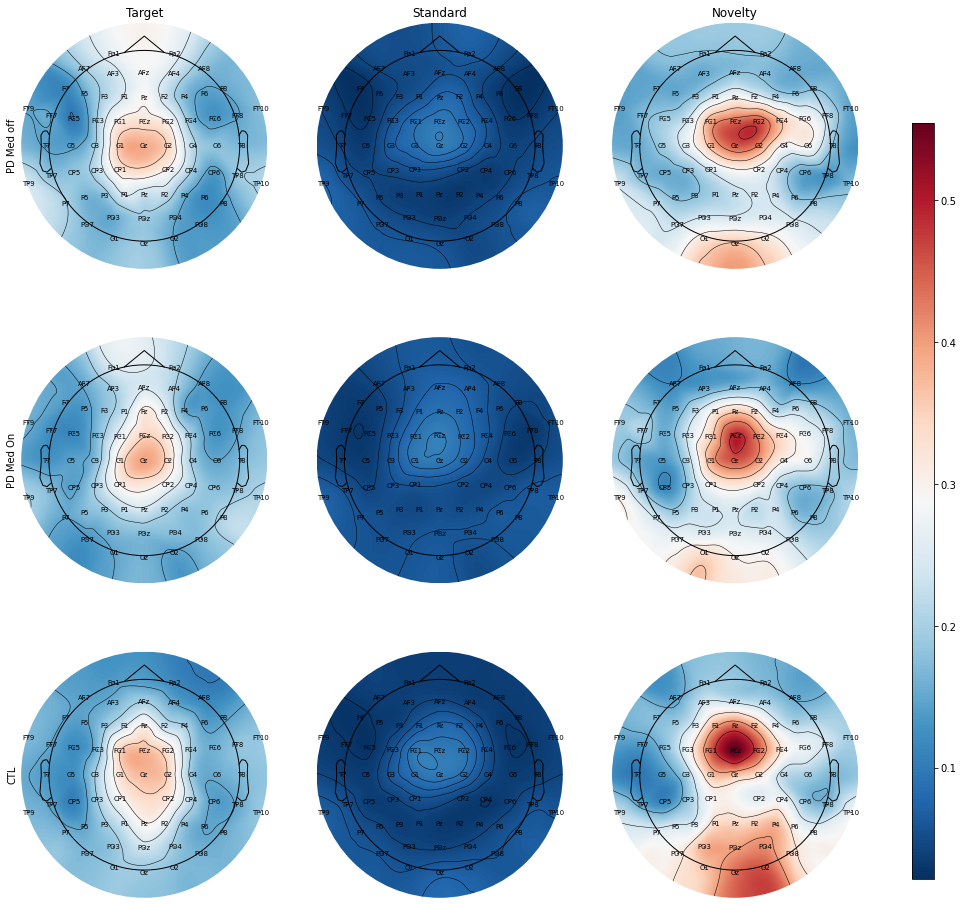

In [6]:
feature_l = 1

feature_h = 8

time_slot = 2

PAC_feature_time_window_grand_mean = np.mean(PAC_feature_time_window[:,:,:,:,feature_h,feature_l,time_slot],axis=1)*1e-12
print(PAC_feature_time_window_grand_mean.shape)

vmax = PAC_feature_time_window_grand_mean.max()
vmin = PAC_feature_time_window_grand_mean.min()  

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))

mne_info = mne.create_info(ch_names=channels_name, sfreq=500., ch_types='eeg')

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')

for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    temp = np.expand_dims(PAC_feature_time_window_grand_mean[i,j,:],axis=1)
    PAC_grand_mean = mne.EvokedArray(temp,mne_info)
    PAC_grand_mean.set_montage(montage)
    im, cm = mne.viz.plot_topomap(PAC_grand_mean.data[:,0], 
                                  PAC_grand_mean.info, axes=axs[i, j], show=False,
                                  names=channels_name, show_names=True, 
                                  vmin=vmin, vmax=vmax,res=200,cmap= 'RdBu_r')

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])
        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
# fname = f'PAC_grand_mean_dur_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}.png' 
       
# if start_time == -200 and end_time==1000:
#         Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-total-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
# else:
#         Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-time_window-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
       
# if not os.path.isdir(Path_dir):
#         os.mkdir(Path_dir)

# file_path = os.path.join(Path_dir,fname)

# plt.savefig(file_path)

## Plot grand mean mutual PAC feature

##### Load mutual PAC feature

In [10]:
Save_path = f'../data/PAC_total_cross_convolution_feature_1_200_1_50_{Convolution_window_h}_{Convolution_window_l}_double.mmap'
PAC_feature_total_cross = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 10,10, Num_High_feature ,Num_Low_feature),mode='r')
print(PAC_feature_total_cross.shape)
print(np.any(PAC_feature_total_cross==0))
print(np.max(PAC_feature_total_cross))

(3, 25, 3, 10, 10, 50, 12)
False
19308049925275.99


### Define axis formatter

In [50]:
# x axis ticks formater
def format_func_x(value, tick_number):
    # find number of multiples of pi/2
    # if tick_number%2 == 1:
    #     return f'({1+4*(value)},{1+4*(value+1)-1})'
    if tick_number%2 == 1:
        return f'{-200+200*(tick_number-1),-200+200*(tick_number)}'
# y axis ticks formater
def format_func_y(value, tick_number):
    # find number of multiples of pi/2
    if tick_number%2 == 1:
        return f'({10+4*(value)},{10+4*(value+1)-1})'

#### Plot mutual PAC grand mean 

(3, 3, 10, 10)


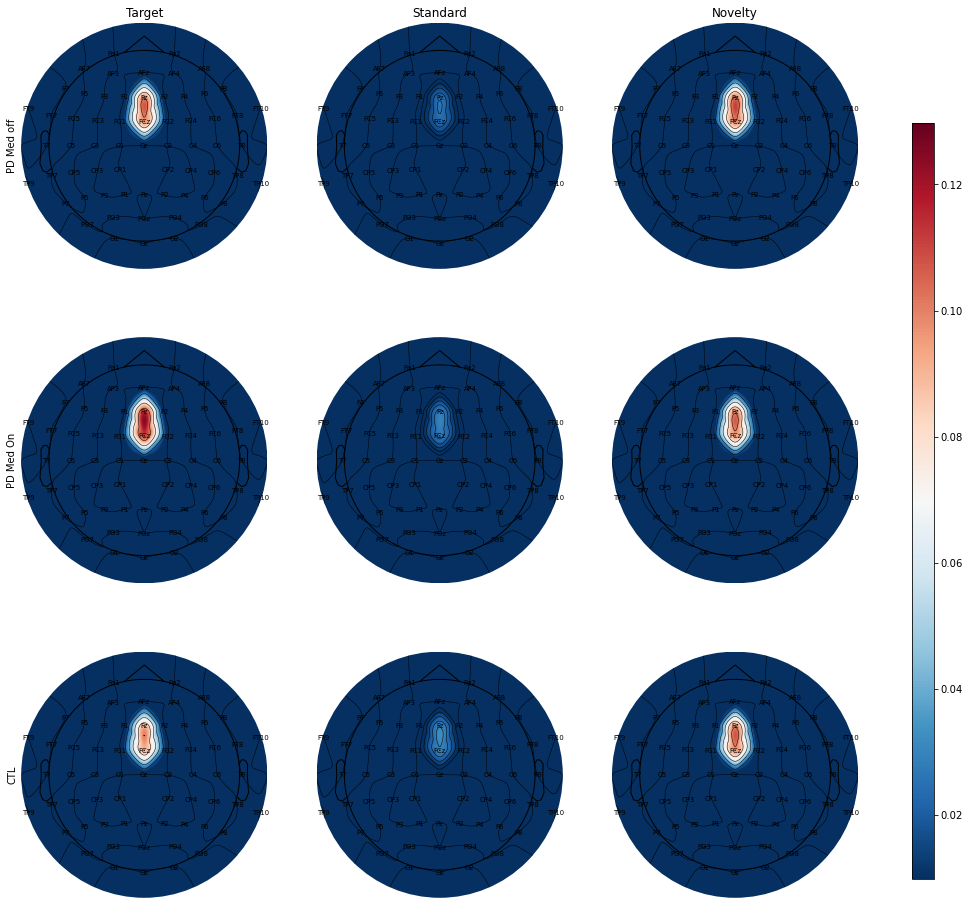

In [28]:
feature_l = 1

feature_h = 8

# ['FC3','FC4','AF3','AF4','F3','F4','Fz','Pz','Cz','FCz']
list_index = [38, 57, 33, 61, 2, 29,1,12,23,39]

ch11 = 6
ch22 = 9

PAC_feature_total_cross_grand_mean = np.mean(PAC_feature_total_cross[:,:,:,:,:,feature_h,feature_l],axis=1)*1e-12
print(PAC_feature_total_cross_grand_mean.shape)

vmax = PAC_feature_total_cross_grand_mean.max()
vmin = PAC_feature_total_cross_grand_mean.min()  

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))

mne_info = mne.create_info(ch_names=channels_name, sfreq=500., ch_types='eeg')

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')

for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    temp = np.zeros(shape=(63,1))
    temp[list_index[ch11],0] = PAC_feature_total_cross_grand_mean[i,j,ch11,ch22]
    temp[list_index[ch22],0] = PAC_feature_total_cross_grand_mean[i,j,ch11,ch22]
#     temp = np.expand_dims(PAC_feature_total_cross_grand_mean[i,j,:,:],axis=1)
    PAC_grand_mean = mne.EvokedArray(temp,mne_info)
    PAC_grand_mean.set_montage(montage)
    im, cm = mne.viz.plot_topomap(PAC_grand_mean.data[:,0], 
                                  PAC_grand_mean.info, axes=axs[i, j], show=False,
                                  names=channels_name, show_names=True, 
                                  vmin=vmin, vmax=vmax,res=200,cmap= 'RdBu_r')

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])
        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
# fname = f'PAC_grand_mean_dur_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}.png' 
       
# if start_time == -200 and end_time==1000:
#         Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-total-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
# else:
#         Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-time_window-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
       
# if not os.path.isdir(Path_dir):
#         os.mkdir(Path_dir)

# file_path = os.path.join(Path_dir,fname)

# plt.savefig(file_path)

### Applying grand mean for each stimuls and channel PAC dynamic

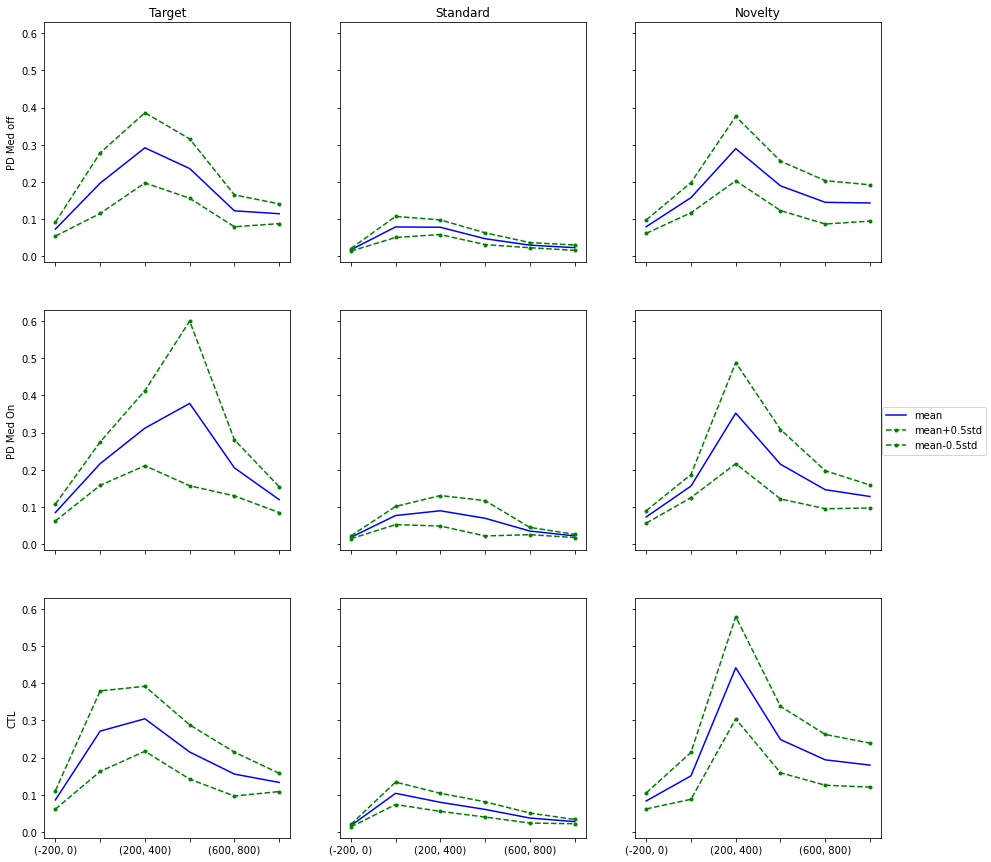

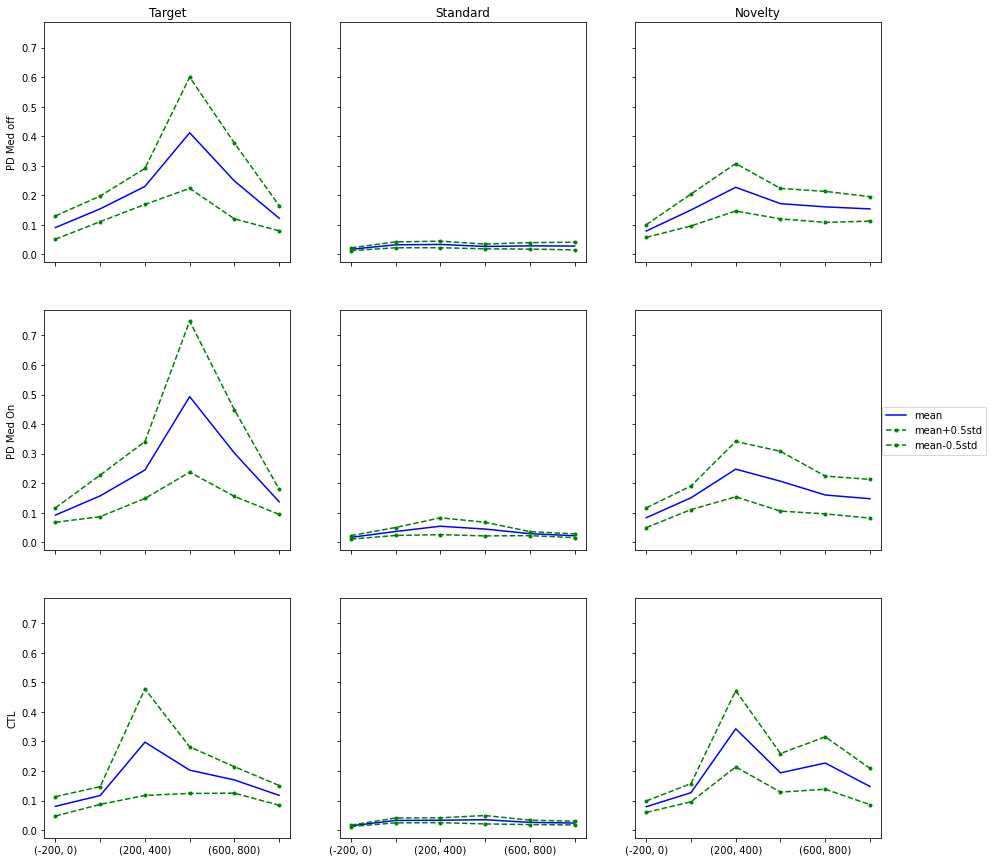

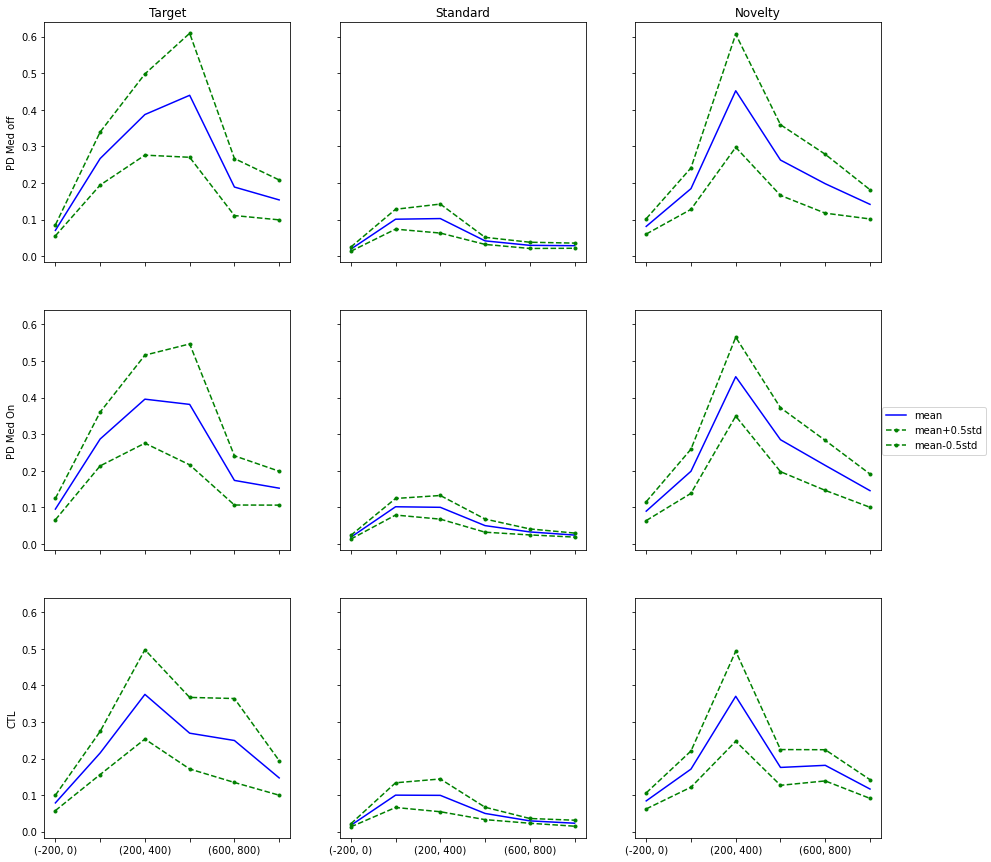

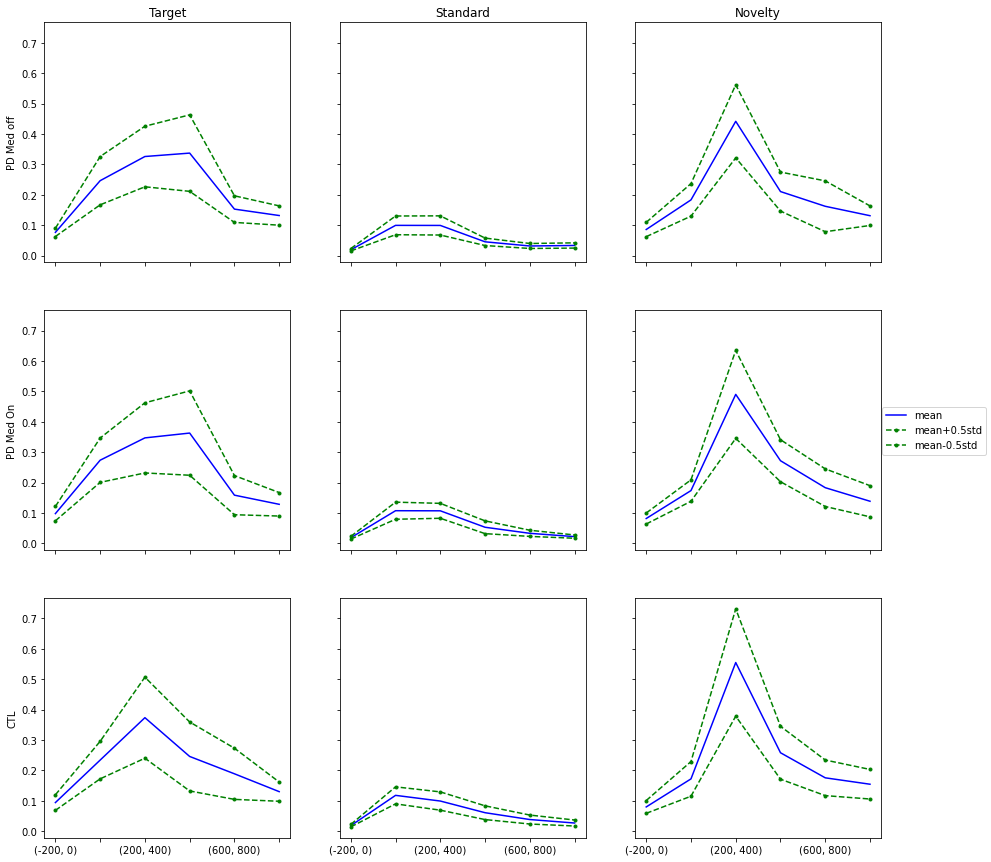

In [53]:
feature_h = 8
feature_l = 1
# ['FC3','FC4','AF3','AF4','F3','F4','Fz','Pz','Cz','FCz']
# list_index = [38, 57, 33, 61, 2, 29,1,12,23,39]

# ['Fz','Pz','Cz','FCz']
list_index = [1, 12, 23, 39]
for ch in list_index:
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
    for i in np.arange(3):
        for j in np.arange(3): 
            mean_plot = np.mean(PAC_feature_time_window[i,:,j,ch,feature_h,feature_l,:]*1e-12,axis=0)
            std_plot = np.std(PAC_feature_time_window[i,:,j,ch,feature_h,feature_l,:]*1e-12,axis=0)
            axs[i,j].plot(mean_plot,color='b',label='mean')
            axs[i,j].plot(mean_plot+0.5*std_plot,linestyle = 'dashed',marker='.',color='g',label='mean+0.5std')
            axs[i,j].plot(mean_plot-0.5*std_plot,linestyle = 'dashed',marker='.',color='g',label='mean-0.5std')
            axs[i,j].xaxis.set_major_formatter(plt.FuncFormatter(format_func_x))
            

    for i in np.arange(3):
        axs[i, 0].set_ylabel(f'{groups[i]}')
        axs[0, i].set_title(event_types[i])

    handles, labels = axs[2,2].get_legend_handles_labels()
    fig.legend(handles, ['mean','mean+0.5std','mean-0.5std'], loc='right')
    # Path_save_fig = f'/mnt/D/Mastersharif/MasterProject/Working_with_kiani/articles/Result_on_articles/time_window_results/PAC_dynamic_ch_{channels_name[ch]}_fh{feature_h}_fl{feature_l}.png' 
    # plt.savefig(Path_save_fig) 



## Load Data for P value calculation

In [ ]:
print(f'../data/PAC_time_series_convolution_feature_10_100_5_30_{Convolution_window_h}_{Convolution_window_l}.mmap')
Path = '../data/PAC_time_series_convolution_feature_10_100_5_30_4_4.mmap'
print(Path)

In [ ]:
# Load PAC feature
# here you can set the dimention of Kernel filter and save path for 
Num_High_fre = 91
Num_Low_fre = 26
Convolution_window_h = 4
Convolution_window_l = 4
Num_High_feature = Num_High_fre // Convolution_window_h
Num_Low_feature = Num_Low_fre // Convolution_window_l
# Path = '../data/PAC_time_series_convolution_feature_13_100_5_30_4_4.mmap'
# PAC_feature_sub_on_electrodes = np.memmap(Path,dtype=float, shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r+')


In [ ]:
Save_path = f'../data/PAC_time_series_convolution_feature_10_100_5_30_{Convolution_window_h}_{Convolution_window_l}_frontal_regions.mmap'
PAC_feature_forental_regions = np.memmap(Save_path,dtype=float ,shape=(3, 25, 3, 63, Num_High_feature ,Num_Low_feature,6),mode='r+')


## Check we have valid data

In [ ]:
index_sorted = np.zeros(shape=(9*25*4*Num_Low_feature*Num_High_feature,6))
counter=0
for i in np.arange(3):
    for sub in np.arange(25):
        for j in np.arange(3):
            for ch in list_index:
                for h in np.arange(Num_High_feature):
                    for l in np.arange(Num_Low_feature):
                        if np.any(PAC_feature_central_regions[i,sub,j,ch,h,l,:]==0):
                            index_sorted[counter,:] = [i,sub,j,ch,h,l]
                        counter = counter + 1 
print(index_sorted.max())

In [ ]:
# np.any(PAC_feature_sub_on_electrodes_kiani[:,:,:,[1,12,23,39],3:24,1:7,:] == PAC_feature_sub_on_electrodes)
a = PAC_feature_sub_on_electrodes_kiani[:,:,:,[1,12,23,39],3:25,1:7,:] 
b = PAC_feature_sub_on_electrodes[:,:,:,[1,12,23,39],:,:,:]


print(a.shape)
print(b.shape)

print(a[0,0,0,0,0,0,4]*1e-12)
print(b[0,0,0,0,0,0,4])
np.linalg.norm(a*1e-12-b)/(np.linalg.norm(a[0,0,0,0,0,0,4]*1e-12))



In [ ]:
pv.shape
list_index

In [ ]:
Path = '../data/PAC_time_series_convolution_feature_13_100_5_30_4_4.mmap'
PAC_time_series_central_regions = 

In [ ]:
for i in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
    print(i)


## P value of feature

In [ ]:
pv = np.zeros((PAC_feature_forental_regions.shape[3], 3, 3, Num_High_feature, Num_Low_feature,6))
# pv = np.zeros((PAC_feature_sub_on_electrodes.shape[3], 3, 3, 16, 4))
# for ch in range(PAC_feature_sub_on_electrodes.shape[3]):
for ch in list_index:    
#     print(ch)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        test_data1, test_data2 = PAC_feature_forental_regions[a, :, j, ch].copy(), PAC_feature_forental_regions[b, :, j, ch].copy()
        # for sub in range(PAC_feature_sub_on_electrodes.shape[1]):
        #     test_data1[:, sub] = sig.convolve2d(test_data1[:, sub], filt_wind, boundary='symm', mode='same')
        #     test_data2[:, sub] = sig.convolve2d(test_data2[:, sub], filt_wind, boundary='symm', mode='same')
        
        t, p = scipy.stats.ttest_ind(test_data1, test_data2,equal_var=False)
        p[p>0.05] = 1
        pv[ch, i, j]=(-np.log(p))

i=1

In [ ]:
# x axis ticks formater
def format_func_x(value, tick_number):
    # find number of multiples of pi/2
    if tick_number%2 == 1:
        return f'({1+4*(value)},{1+4*(value+1)-1})'
# y axis ticks formater
def format_func_y(value, tick_number):
    # find number of multiples of pi/2
    if tick_number%2 == 1:
        return f'({10+4*(value)},{10+4*(value+1)-1})'

gamma = [1, 16]
beta  = [ 1, 4]
def plot_pac(pac, high_freq=gamma, low_freq=beta, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation='nearest', #'nearest',
#                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq),cmap='RdBu_r',**kwargs)

    if ax is None:
        plt.show()
        
    return im       

In [ ]:
# Path_to_save_fig = 'D:\Mastersharif\MasterProject\Working_with_kiani\\articles\Result_on_articles\Cbar_Corrected'
Path_to_save_fig = '/mnt/D/Mastersharif/MasterProject/Working_with_kiani/articles/Result_on_articles/time_window_results'
temp = pv.sum(axis=0)
vmax = temp.max()
vmin = temp.min()
time_Window_slot = 3
max_1 = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
for i, j in itertools.product(range(3), range(3)):
    im = plot_pac(temp[i, j,:,:,time_Window_slot], ax=axs[i, j],vmin=vmin, vmax=vmax)
#                       vmin=vmin vmax=vmax)

    axs[i, j].xaxis.set_visible(False)
    axs[i, j].yaxis.set_visible(False)
    axs[i,j].xaxis.set_major_formatter(plt.FuncFormatter(format_func_x))
    axs[i,j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_y))
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)

fname = f'PAC_time_window_{time_Window_slot}_forental_regions.png'
file_path = os.path.join(Path_to_save_fig, fname)
plt.savefig(file_path)    

In [ ]:
a=np.array([[3,2,5],[8,1,2],[6,6,7],[3,5,1]])
index = np.linspace(a.shape[0]-1,0,a.shape[0]).astype(np.int32)
a[index,:]


## How imshow plot work

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

A=np.array([[3,2,5],[8,1,2],[6,6,7],[3,5,1]]) #The array to plot

im=plt.imshow(A,origin="lower",interpolation="nearest",cmap=plt.cm.gray_r)
plt.colorbar(im)

## Plot topography of important feature


In [ ]:
Path_to_save_fig = 'D:\Mastersharif\MasterProject\Working_with_kiani\\articles\Result_on_articles\\topography'

feature_h = 0
feature_l = 1
with open('..\data\channels_name.pkl', 'rb') as f:
        channels_name = pickle.load(f)
PAC_feature_sub_on_electrodes_gm = np.mean(PAC_feature_sub_on_electrodes[:,:,:,:,feature_h,feature_l],axis=1)
vmin = np.min(PAC_feature_sub_on_electrodes_gm)
vmax = np.max(PAC_feature_sub_on_electrodes_gm)
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))

mne_info = mne.create_info(ch_names=channels_name, sfreq=500., ch_types='eeg')

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')

for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    temp = np.expand_dims(PAC_feature_sub_on_electrodes_gm[i,j,:],axis=1)
    PAC_grand_mean = mne.EvokedArray(temp,mne_info)
    PAC_grand_mean.set_montage(montage)
    im, cm = mne.viz.plot_topomap(PAC_grand_mean.data[:,0], 
                                  PAC_grand_mean.info, axes=axs[i, j], show=False,
                                  names=channels_name, show_names=True, 
                                  vmin=vmin, vmax=vmax,res=200,cmap= 'RdBu_r',fontsize='medium')

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])
        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
fname = f'feature_h_{feature_h}_feature_l_{feature_l}_RdBu_r'
file_path = os.path.join(Path_to_save_fig, fname)
plt.savefig(file_path)

## P values on channel

In [ ]:
feature_h = 0
feature_l = 1
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
# vmin, vmax = mvls.mean(axis=1).min(), mvls.mean(axis=1).max() #get_percent(mvls.mean(axis=1), 0.95)
for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
    a, b = grp[0]
    i = grp[1]
    data_a = PAC_feature_sub_on_electrodes[a, :, j, :, feature_h, feature_l]
    data_b = PAC_feature_sub_on_electrodes[b, :, j, :, feature_h, feature_l]
    t, p = scipy.stats.ttest_ind(data_a, data_b)
    p[p>0.05] = 1
    p = p.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(-np.log(p) ,#- -np.log(p).mean(),
                                  mne_info)
    mvl_evoked.set_montage(montage)
    im, cm = mne.viz.plot_topomap(mvl_evoked.data[:, 0], 
                                  mvl_evoked.info, axes=axs[i, j], 
                                  show=False,
                                  names=channels_name, show_names=True, cmap='RdBu_r')
    #, vmin=vmin- mvls.mean(), vmax=vmax- mvls.mean())

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
fname = f'p_value_feature_h_{feature_h}_feature_l_{feature_l}_RdBu_r'
file_path = os.path.join(Path_to_save_fig, fname)
plt.savefig(file_path)